# 7. Maximum Likelihood fit



In [1]:
import skgstat as skg
from skgstat.util.likelihood import get_likelihood
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from time import time
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

We use the pancake dataset, sampled at 300 random locations to produce a quite dense sample.

In [2]:
# use the same dataset as used in GMD paper
c, v = skg.data.pancake(N=300, seed=42).get('sample')

First of, the variogram is calculated. We use Scott's rule to determine the number of lag classes, explicitly set Trust-Region Reflective as fitting method (although its default) and limit the distance matrix to 70% of the maximum separating distance.
Additionally, we capture the processing time for the whole variogram estimation. Note, that this also includes the calculation of the distance matrix, which is a mututal step.

Processing time: 727 ms
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   326.72
Sill:              1584.49
Nugget:            0.00
        


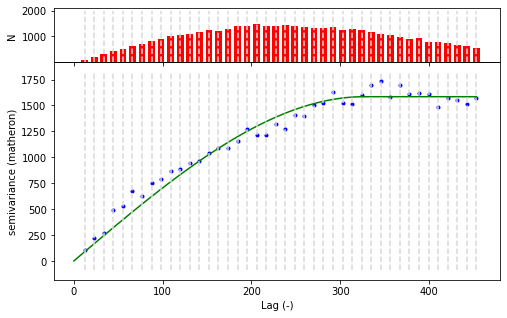

In [3]:
t1 = time()
V = skg.Variogram(c,v, bin_func='scott', maxlag=0.7, fit_func='trf')
t2 = time() # get time for full analysis, including fit
print(f"Processing time: {round((t2 - t1) * 1000)} ms")
print(V)
fig = V.plot()

## Maximum likelihood using SciKit-GStat

Since version ``0.6.12`` SciKit-GStat implements an utility function factory which takes a Variogram instance and builds up a (negative) maximum likelihood function for the associated sample, distance matrix and model type. The used function is defined in eq. 14 from Lark (2000). Eq. 16 from same publication was adapted to all available theoretical models available in SciKit-GStat, with the exception of the harmonized model, which does not require a fitting.

First step to perform the fitting is to make initial guesses for the parameters. Here, we take the mean separating distance for the effective range, the sample variance for the sill and 10% of the sample variance for the nugget. To improve performance and runtime, we also define a boundary to restrict the parameter space. 

In [4]:
# base initial guess on separating distance and sample variance
sep_mean = V.distance.mean()
sam_var = V.values.var()
print(f"Mean sep. distance:  {sep_mean.round(1)}    sample variance: {sam_var.round(1)}")

# create initial guess
#    mean dist.  variance    5% of variance
p0 = np.array([sep_mean, sam_var, 0.1 * sam_var])
print('initial guess: ', p0.round(1))

# create the bounds to restrict optimization
bounds = [[0, V.bins[-1]], [0, 3*sam_var], [0, 2.9*sam_var]]
print('bounds:        ', bounds)


Mean sep. distance:  253.5    sample variance: 1298.9
initial guess:  [ 253.5 1298.9  129.9]
bounds:         [[0, 453.28247263709636], [0, 3896.6137], [0, 3766.7265766666665]]


Next step is to pass the Variogram instance to the function factory. We find optimal parameters by minimizing the returned negative log-likelihood function. Please refer to SciPy's minimize function to learn about attributes. The returned function from the utility suite is built with SciPy in mind, as the function signature complies to SciPy's interface and, thus can just be passed to the minimize function.
Here, we pass the initial guess, the bounds and set the solver method to SLSQP, a suitable solver for bounded optimization.

In [5]:
# load the likelihood function for this variogram
likelihood = get_likelihood(V)

# minimize the likelihood function 
t3 = time()
res = minimize(likelihood, p0, bounds=bounds, method='SLSQP')
t4 = time()
print(f"Processing time {np.round(t4 - t3, 2)} seconds")

Processing time 3.49 seconds


In [6]:
print('initial guess:     ', p0.round(1))
print('optimal parameters:', res.x.round(1))

initial guess:      [ 253.5 1298.9  129.9]
optimal parameters: [ 184.2 1311.9    7.2]


Apply the optimized parameters. For comparison, the three method-of-moment methods from SciKit-GStat are applied as well. Note that the used sample is quite dense. Thus we do not expect a different between the MoM based procedures. They should all find the same paramters.

In [7]:
# use 100 steps
x = np.linspace(0, V.bins[-1], 100)

# apply the maximum likelihood fit parameters
y_ml = V.model(x, *res.x)

# apply the trf fit
y_trf = V.fitted_model(x)

# apply Levelberg marquard
V.fit_method = 'lm'
y_lm = V.fitted_model(x)

# apply parameter ml
V.fit_method = 'ml'
y_pml = V.fitted_model(x)

# check if the method-of-moment fits are different
print('Trf and Levenberg-Marquardt identical: ', all(y_lm - y_trf < 0.1))
print('Trf and parameter ML identical:        ', all(y_pml - y_trf < 0.1))

Trf and Levenberg-Marquardt identical:  True
Trf and parameter ML identical:         True


Make the result plot

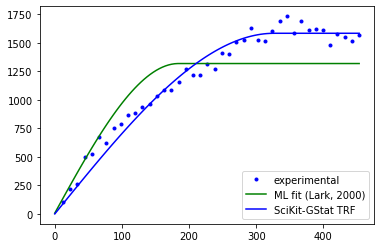

In [8]:
plt.plot(V.bins, V.experimental, '.b', label='experimental')
plt.plot(x, y_ml, '-g', label='ML fit (Lark, 2000)')
plt.plot(x, y_trf, '-b', label='SciKit-GStat TRF')
plt.legend(loc='lower right')
#plt.gcf().savefig('compare.pdf', dpi=300)

## Build from scratch

SciKit-GStat's utility suite does only implement the maximum likelihood approach as published by Lark (2000). There are no settings to adjust the returned function, nor use other implementations. If you need to use another approach, the idea behind the implementation is demonstrated below for the spherical variogram model. This solution is only build on SciPy and does not need SciKit-GStat, in case the distance matrix is build externally.

In [9]:
from scipy.spatial.distance import squareform
from scipy.linalg import inv, det

# define the spherical model only dependent on the range
def f(h, a):
    if h >= a:
        return 1.
    elif h == 0:
        return 0.
    return (3*h) / (2*a) - 0.5 * (h / a)**3

# create the autocovariance matrix 
def get_A(r, s, b, dists):
    a = np.array([f(d, r) for d in dists])
    A = squareform((s / (s + b)) * (1 - a))
    np.fill_diagonal(A, 1)

    return A

# likelihood function
def like(r, s, b, z, dists):
    A = get_A(r, s, b, dists)
    n = len(A)
    A_inv = inv(A)
    ones = np.ones((n, 1))
    z = z.reshape(n, -1)
    m = inv(ones.T @ A_inv @ ones) @ (ones.T @ A_inv @ z)
    b = np.log((z - m).T @ A_inv @ (z - m))
    d = np.log(det(A))
    if d == -np.inf:
        print('invalid det(A)')
        return np.inf
    loglike = (n / 2)*np.log(2*np.pi) + (n / 2) - (n / 2)* np.log(n) + 0.5* d + (n / 2) * b
    return loglike.flatten()[0]

In [10]:
from scipy.optimize import minimize
from scipy.spatial.distance import pdist

# c and v are coordinate and values array from the data source
z = np.array(v)

# in case you use 2D coordinates, without caching and euclidean metric, skgstat is using pdist under the hood
dists = pdist(c)

fun = lambda x, *args: like(x[0], x[1], x[2], z=z, dists=dists)
t3 = time()
res = minimize(fun, p0, bounds=bounds)
t4 = time()
print(f"Processing time {np.round(t4 - t3, 2)} seconds")

Processing time 2.87 seconds


In [11]:
print('initial guess:     ', p0.round(1))
print('optimal parameters:', res.x.round(1))

initial guess:      [ 253.5 1298.9  129.9]
optimal parameters: [ 184.2 1312.9    7.2]


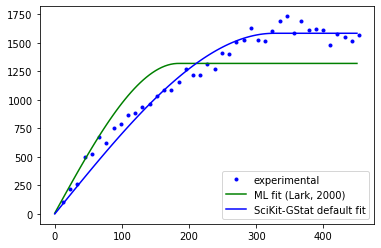

In [12]:
import matplotlib.pyplot as plt
mod = lambda h: f(h, res.x[0]) * res.x[1] + res.x[2]

x = np.linspace(0, 450, 100)
y = list(map(mod, x))
y2 = V.fitted_model(x)

plt.plot(V.bins, V.experimental, '.b', label='experimental')
plt.plot(x, y, '-g', label='ML fit (Lark, 2000)')
plt.plot(x, y2, '-b', label='SciKit-GStat default fit')
plt.legend(loc='lower right')
plt.gcf().savefig('compare.pdf', dpi=300)